# The FireworQS: Sorana Aurelia & Erica Sturm
### Womanium 2024 QML Project: Quantum Machine Learning for Conspicuity Detection in Production
### Notebook 3

This Jupyter Notebook covers Task 3 of the quantum machine learning challenge given by Fraunhofer. Tasks 0, 1, and 2 are covered elsewhere. We make use of standard markdown notation as well as several HTML tags which may not render in the intended manner. However, these issues are merely cosmetic and will not alter the content.

## Guided Walkthrough of "Quanvolutional Neural Networks"
In this notebook we walk our audience through the PennyLane tutorial titled ["Quanvolutional Neural Networks"](https://pennylane.ai/qml/demos/tutorial_quanvolution/) or QNNs for short. The demo begins by crediting the work of [Henderson, Shakya, Pradhan, and Cook](https://arxiv.org/abs/1904.04767) as the original source material and providing a visual representation of the overall workflow of this ML approach. This is a classical-quantum hybrid approach where the original authors' contribution is that they introduce a new type of layer in place of the versions used in purely classical neural networks which we briefly discussed in the second notebook of this project.

**An important note about acronyms:**
* **NN = neural network**
* **CNN = convolutional neural network**
* **CCNN = classical convolutional neural network**
* **QNN = quanvolutional neural network**

Contents:
* [Introduction](#intro)
* [General Setup](#setup)
* [Setting of the main hyper-parameters of the model](#hparam_setting)
* [Loading of the MNIST dataset](#mnist)
* [Quantum circuit as a convolution kernel](#qc_conv_ker)
* [Quantum pre-processing of the dataset](#preprocessing)
* [Hybrid quantum-classical model](#hybrid)
* [Training](#training)

Before we begin the walk-through, we begin by installing PennyLane and then TensorFlow. These two cells might not be required depending on the host's `environment.` We have surpressed the `STDOUT` of the cells below for clarity. For the TensorFlow installation we recieved several runtime errors when executing `import tensorflow as tf` line in the [General Setup](#setup) section. A little searching brought us to [this webpage](https://github.com/tensorflow/tensorflow/issues/62075) where we found a solution. We thank the authors of the post that assisted us.

In [1]:
%pip install -U pennylane

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install -U tensorflow[and-cuda]

  Obtaining dependency information for nvidia-cublas-cu12==12.3.4.1 from https://files.pythonhosted.org/packages/74/aa/f0e402ab0c1aa371e3143ed0b79744ebd6091307087cda59e3249f45cac8/nvidia_cublas_cu12-12.3.4.1-py3-none-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for nvidia-cuda-cupti-cu12==12.3.101 from https://files.pythonhosted.org/packages/6a/43/b30e742c204c5c81a6954c5f20ce82b098f9c4ca3d3cb76eea5476b83f5d/nvidia_cuda_cupti_cu12-12.3.101-py3-none-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for nvidia-cuda-nvcc-cu12==12.3.107 from https://files.pythonhosted.org/packages/4a/d9/352879c1d749b787b5c068b32673a73ce1cb6c52874b1d2e80044b101485/nvidia_cuda_nvcc_cu12-12.3.107-py3-none-manylinux1_x86_64.whl.metadata
  Obtaining dependency information for nvidia-cuda-nvrtc-cu12==12.3.107 from https://files.pythonhosted.org/packages/0b/dd/c510983b0fb66b7346432e1f25afbfd9446a86ccdbfacb600351aa8e09d6/nvidia_cuda_nvrtc_cu12-12.3.107-py3-none-manylinux1_x86_64

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/412.6 MB 7.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 26.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 26.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 27.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.7/867.7 kB 23.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.7/704.7 MB 4.9 MB/s eta 0:00:00:00:0100:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 MB 18.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 MB 15.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.5/197.5 MB 12.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 12.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━

## Introduction<a class="anchor" id="intro"></a>
The demo begins with a brief discussion about classical versus quantum CNNs. A convolution takes two functions as inputs and outputs a third according to the following mathematics:  

$(f*g)(t) := \int^{\infty}_{-\infty}f(\tau)g(t-\tau)d\tau = \int^{\infty}_{-\infty}f(t-\tau)g(\tau)d\tau$  

The above equation would be stated as "function f is convolved with function g." The variable $t$ need not represent time, but it is common and therefore the default. In a very basic sense, a convolution takes one function, reflects it over the Y-axis and then examines how one function's shape modifies the shape of the other as the functions are made to pass across or "shift" through one another. This is why $t$ might represent time, but it does not have to, it just provides ordering. 

The Introduction part of the demo notes that CCNNs are very popular ML models and are well suited for image recognitition. Instead of a large feed-forward NN that might be required for a full image to be processed, the image is broken down into smaller neighborhoods and fed (in order) to the same model. The difference here is that because of the convultion between layers, these CNN models do not need to look at every pixel of an image separately (which is what a standard NN would need); instead it looks at small neighborhoods and the convolution mathematics between each subsequent layer determines whether or not the next layer is activated by a *region*. In the end, a single output node or pixel is activated.

This is particularly useful, if for example we were trying to determine whether (for example) a given image has a cat. Is the cat in the upper left corner? The center? By looking at regions and how they influence each other by way of convolution, the machine can better "see" what is in the image by recognizing broader patterns or features and abstracting them layer by layer.

The demo's introdcution then enumerates the steps that a QNN would take that parallel the classical counterpart. The image is still broken down into small regions, but this time the image is embedded into a quantum circuit using parameterized rotations and then a unitary operation is applied. The expectation value is measured and post processing may commence if needed. This consitutes a layer. The extracted expectation value is then mapped to a single output pixel (just like the classical case). This process is then repeated for the next region of the image. 

The introdution concludes with a remark that we will not be training the quantum circuit and instead use a constant quanvolution kernel, while the classical layers that follow will be trained. The quanvolution kernel could be trained, but that is outside the scope of this tutorial. 

## General Setup<a class="anchor" id="setup"></a>
Unsurprisingly, we begin with importing all sorts of modules including PennyLane, the PennyLane version of NumPy (not the vanilla kind!), and we will be using TensorFlow for our NN needs. MatPlotLib will be used, as always, to make pretty images so that us mere mortals can see what's going on.

In [6]:
# FQS: the code here has not been altered.

import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

## Setting of the main hyper-parameters of the model<a class="anchor" id="hparam_setting"></a>
This section is setting several hyperparameters required for neural network initialization. We will not explain these terms as there are myriad superior resources for these. Note that a directory is created for saving the data in line 8. If the reader wishes to rename or redirect this output, we encourage them to alter this line appropriately! But we have elected to leave it as it appears in the tutorial. 

In [19]:
# FQS: the code here has not been altered.

n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "../_static/demonstration_assets/quanvolution/"  # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
np.random.seed(0)           # Seed for NumPy random number generator
tf.random.set_seed(0)       # Seed for TensorFlow random number generator

## Loading of the MNIST dataset<a class="anchor" id="mnist"></a>
The MNIST dataset contains tens of thousands of images of handwritten numbers from 0 to 9. According to the lead authors' [website](https://yann.lecun.com/exdb/mnist/), the set has 60,000 training trials and another 10,000 trials for testing. The images are all the same size (normalized) and the digits are centered within the image. This is a foundational set that everyone encounters, whether it is as a first-time ML student, or when benchmarking a new ML technique. 

The PennyLane demo notes that we will not be using the full dataset for this tutorial to expedite our efforts, but as a consequence our results will not be as accurate as they would be with the full set. The code cell below loads the MNIST dataset (lines 3 and 4) and takes a targetted subset for our usage (lines 6-10). Then, all of the colors of the data are normalized so that each pixel in each image has some floating point value between 0 and 1 instead of an integer between 0 and 255 (lines 12-14). Finally, we add an extra dimension called `tf.newaxis` at the end of each unrolled image's ray. We note that since this being treated as an element of the input array, it does not require training and therefore `requires_grad=False`.

In [8]:
# FQS: the code here has not been altered.

mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Quantum circuit as a convolution kernel<a class="anchor" id="qc_conv_ker"></a>
The tutorial now walks us through the creation of the QCNN, starting with the instantiation of a PennyLane device and `qnode` decorated circuit function. We will be using the PennyLane classical simulator `default.qubit` for four qubits as shown in line 3. The `qnode` decorated quantum `circuit` function encodes four classical values onto the qubits via amplitude embedding which we saw in Example 2 of Notebook 2 of this project. That is, instead of directly embedding binary values, rotation gates are applied to invidual wires such that the real values are encoded in the probability amplitudes of the statevector. A random circuit of `n` layers are applied to the wires and then measurements are taken in the form of expectation values.

In [9]:
# FQS: the code here has not been altered.

dev = qml.device("default.qubit", wires=4)
# Random circuit parameters
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

Now we need a convolution framework. Each of the images will be split into squares of 2x2 pixels. These regions will be process by running them through the above `circuit` and then the expcetation values that are output at the end are each mapped to different channels of ONE output pixel. This is akin to what happens in a CCNN, where each subsection of an image is processed by a network and then that activates a single output pixel, the primary difference being that we used a quantum computer to do this subsection processing.

The tutorial points out that this is like saying "we have a 2x2 kernel with a stride of 2" if this were a CCNN setup. 

The next code cell below is the subroutine that executes a "quanvolution" (quantum convolution). A single image is passed in as an argument and broken down into subsections via two nested for loops in lines 8 and 9. Each little subsection is indexed by its upper left pixel, and each of those 2x2 subsections are sent to the `circuit` routine above. We wish to draw a clear connection between the four pixels of the subsection which are selected between lines 12 and 17 stored in a list object that become the angles of rotation in the `circuit` routine, one for each wire/qubit. Recall that each expectation value will be a floating point value between 0 and 1. The four returned values are then minimally processed (line 21) to assign them to different channels of the output and the results are stored in a three dimensional NumPy array. The iterator then moves to the next little 2x2 subsection and repeats the process.

We note again that the quantum convolution layer will not be trained/optimized, but it could be if desired.

In [10]:
# FQS: the code here has not been altered.

def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    # Loop over the coordinates of the top-left pixel of 2X2 squares
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            # Process a squared 2x2 region of the image with a quantum circuit
            q_results = circuit(
                [
                    image[j, k, 0],
                    image[j, k + 1, 0],
                    image[j + 1, k, 0],
                    image[j + 1, k + 1, 0]
                ]
            )
            # Assign expectation values to different channels of the output pixel (j/2, k/2)
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

## Quantum pre-processing of the dataset<a class="anchor" id="preprocessing"></a>
Instead of optimizing the quantum circuit, the tutorial notes that it is more efficient use the quantum circuit we just designed as a sort of pre-processing step for all of our training data and therefore we are not running a quantum circuit over and over. (Running a quantum circuit repeatedly is expensive to do on a classical simulator and would require *significant* effort on a real quantum computer as we would need to run an enormous number of shots!). The subsequent classical model will be trained on these quantum-prep-processed data.

To prevent the quantum step being repeated, the pre-processed data are saved and can be loaded later. Then the `PREPROCESS` variable can be set to `False` and the whole `if` block can be skipped in that case. We have left the `True` value here in line 3, but if one wanted to run this block again, one would be advised to switch the truth value.

(As a side comment we strongly encourage the reader to ensure that they check their spelling when creating the path for the storage directory, because an extra 's' in the word assets creates all kinds of problems! Don't ask us why we know this...)

In [20]:
# FQS: the code here has not been altered.

if PREPROCESS == True:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


We can now have a look at what a single convolutional layer did! Remember, in a sense we are "downsampling" the original images by slicing them up into little 2x2 pixel squares--this reduces the resolution. Each of the quantum circuit's outputs (the four expectation values) map to a different output pixel channel, and we can see that below. Note how the four output channels are more pixelated than the top row with the input. But, the general shape of the input is maintained in each of the outputs.

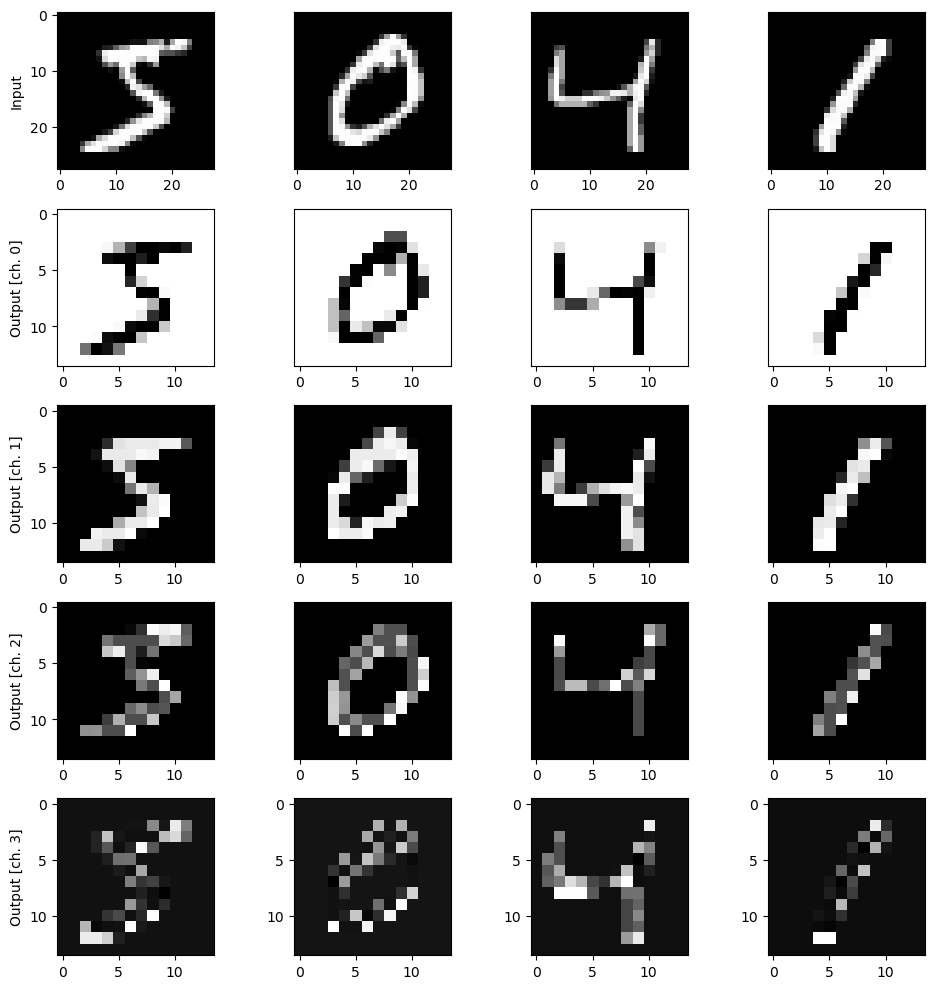

In [21]:
# FQS: the code here has not been altered.

n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

## Hybrid quantum-classical model<a class="anchor" id="hybrid"></a>
Now that we have done our 'quantum circuit pre-processing' step via the QCNN, we take the outputs and use them as inputs in a CNN. We will be using keras for this, and it will be a standard fully connected feed-forward NN. The inputs dimension corresponds to the output from the QCNN (4) and the output dimension will match the number of different cases (10; one for each digit in the Arabic numeral system). As the following cell is a CNN, we will not explain the code in great detail, just a high level overview.

Recall that we defined several training hyperparameters [earlier](hparam_setting). We note that this fully connected NN uses the popular ADAM optimizer and the `softmax` activation function, which is another popular choice along with ReLU. The optimizer helps the model determine which combination of node weights and biases perform the best according to the loss function. While gradient descent is probably the most popular to use as a teaching tool as it readily accessible to anyone with first semester calculus, the ADAM optimizer performs better for NN applications. The loss function here is `sparse_categorical_crossentropy` which the [TensorFlow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy) explains that this is the loss function that one would use when the labels (for the output targets) are integers, as is true in our case here with the MNIST dataset. Finally, the activation function basically determines whether or not a node is used or "activated" within a given layer. If one thinks of each layer of a NN being akin to a linear equation with scalar coefficients, the activation function decides which nodes get to contribute to the equation. 

In [22]:
# FQS: the code here has not been altered.

def MyModel():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

## Training<a class="anchor" id="training"></a>
Okay, we're ready to use everything together now and train our classifier! We must initialize the model first, then train it using our (subset) of MNIST training data. We then use the validation set to refine the model (note that the validation set must also recieve identical preprocessing through the QCNN so that the trials are all consistent).

In [23]:
# FQS: the code here has not been altered.

q_model = MyModel()

q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 42ms/step - accuracy: 0.1800 - loss: 2.7102 - val_accuracy: 0.3667 - val_loss: 2.0745
Epoch 2/30
13/13 - 0s - 3ms/step - accuracy: 0.3600 - loss: 1.9325 - val_accuracy: 0.3333 - val_loss: 2.0531
Epoch 3/30
13/13 - 0s - 3ms/step - accuracy: 0.6400 - loss: 1.6016 - val_accuracy: 0.4333 - val_loss: 1.9326
Epoch 4/30
13/13 - 0s - 3ms/step - accuracy: 0.7200 - loss: 1.2912 - val_accuracy: 0.4000 - val_loss: 1.7522
Epoch 5/30
13/13 - 0s - 3ms/step - accuracy: 0.8200 - loss: 1.0690 - val_accuracy: 0.5333 - val_loss: 1.6580
Epoch 6/30
13/13 - 0s - 3ms/step - accuracy: 0.8600 - loss: 0.8928 - val_accuracy: 0.5667 - val_loss: 1.5871
Epoch 7/30
13/13 - 0s - 3ms/step - accuracy: 0.9000 - loss: 0.7500 - val_accuracy: 0.6667 - val_loss: 1.5166
Epoch 8/30
13/13 - 0s - 3ms/step - accuracy: 0.9600 - loss: 0.6388 - val_accuracy: 0.6667 - val_loss: 1.4593
Epoch 9/30
13/13 - 0s - 3ms/step - accuracy: 0.9600 - loss: 0.5482 - val_accuracy: 0.6667 - val_loss: 1.4143
Epoch 10/30
13/13 

The tutorial then explains that we will compare these results with that of a classical-only model without the quantum pre-processing step. The same (normalized) training and validation sets are used, we are simply skipping the quantum circuit part. The architecture of the classical NN is unchanged, as are the hyperparameters (eg: epochs and batch size) from the hybrid model, so this truly is a fair comparison.

In [24]:
# FQS: the code here has not been altered.

c_model = MyModel()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 47ms/step - accuracy: 0.0600 - loss: 2.3954 - val_accuracy: 0.0333 - val_loss: 2.3120
Epoch 2/30
13/13 - 0s - 3ms/step - accuracy: 0.3400 - loss: 1.9806 - val_accuracy: 0.2000 - val_loss: 2.1427
Epoch 3/30
13/13 - 0s - 3ms/step - accuracy: 0.5800 - loss: 1.6904 - val_accuracy: 0.3333 - val_loss: 1.9875
Epoch 4/30
13/13 - 0s - 3ms/step - accuracy: 0.7400 - loss: 1.4480 - val_accuracy: 0.4000 - val_loss: 1.8467
Epoch 5/30
13/13 - 0s - 3ms/step - accuracy: 0.9600 - loss: 1.2423 - val_accuracy: 0.4333 - val_loss: 1.7246
Epoch 6/30
13/13 - 0s - 3ms/step - accuracy: 0.9600 - loss: 1.0692 - val_accuracy: 0.4333 - val_loss: 1.6222
Epoch 7/30
13/13 - 0s - 3ms/step - accuracy: 0.9800 - loss: 0.9249 - val_accuracy: 0.6000 - val_loss: 1.5372
Epoch 8/30
13/13 - 0s - 3ms/step - accuracy: 1.0000 - loss: 0.8053 - val_accuracy: 0.6333 - val_loss: 1.4669
Epoch 9/30
13/13 - 0s - 3ms/step - accuracy: 1.0000 - loss: 0.7060 - val_accuracy: 0.6333 - val_loss: 1.4085
Epoch 10/30
13/13 

## Results<a class="anchor" id="results"></a>
That's it, we made it to the end! We are now ready to compare the hybrid approach with the purely classical. Running the code cell below creates a runtime warning on line 5 about the Seaborn API within MatPlotLib. The plotting program still works, but notes that this style is deprecated. We did not choose to alter this as there are a million different ways to visualize data. But since this is a runtime warning and not a code-ending error, we leave it alone.

/tmp/ipykernel_2436005/862237949.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


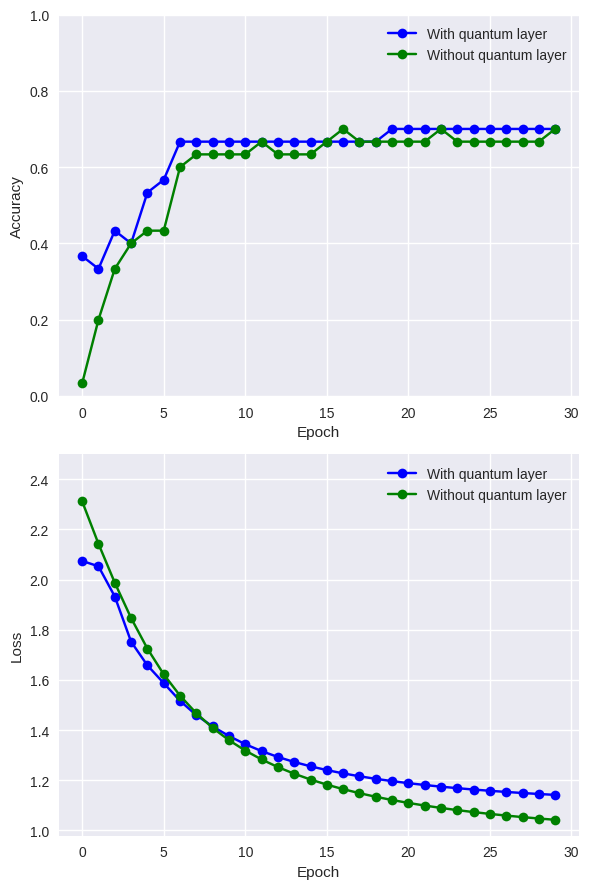

In [25]:
# FQS: the code here has not been altered.

import matplotlib.pyplot as plt

plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()
plt.tight_layout()
plt.show()

Getting back to the graphs above, we note that the hybrid algorithm has better accuracy by a little bit (top graph), but has a higher loss (bottom graph) compared to the purely classical appraoch. However, in the webpage version, the purely clasical algorithm has higher accuracy in addition to lower losses. 

In this final analysis we note that our graphs here look different than that sen in the tutorial webpage. This might be due to the random nature of the quantum layer we initalized (a different random circuit might be a better or worse preprocessing step), but we also note that the classical data is also different. This might be due the random nature of the batching step--while the subset of the MNIST dataset is consistently used, the trials that make it into each batch would have been different. It is difficult to quantify this effect as 30 epochs should have been enough to mitigate this randomized batching. One way we could test this is by setting the random seed (after selecting the same training subset), but that is not the purpose of this document. We also reiterate a point made earlier, that the quantum layer could also be optimized/trained, but here it was just random. One would assume and hope that an optimized preprocessing step would further improve the hybrid approach, possibly by speeding up the covergence of the accuracy or loss, or simply attaining better values in the same number of epochs.

## Final Remarks
Over the course of these three notebooks, we have reviewed several key features of the PennyLane module that make it particularly suitable for quantum machine learning. Firstly, it provides an excellent series of codebooks that introduce the relevant quantum mechanical principles for quantum computing without getting bogged down in the finer nuances that sometimes derail more physics/mathematics-oriented approaches. These ideas are seamless reinforced through a wonderful integration of code challenges where we were able to see the lesson materials in action by working through code challenges that introduced us to the most fundamental details of using PennyLane. These two learning goals (quantum computing and PennyLane usage) were made to reinforce each other, and it was actually pretty fun to work through some of the codercises!

We also worked through several examples of using PennyLane in real-world-inspired examples including variational classifiers and quantum-classical hybrid models. In the former we looked at different ways to encode input data. In the latter we saw how even a very rudimentarly quantum convolutional step could dramatically alter a machine learning model's results. Finally, we also had some exposure to the JAX module, which opens the door to using PennyLane much more effectively via just-in-time compilation, parallelization mappings, and auto-differentiation. While we did not do a deep dive on this topic, the introduction provided us with ideas about just how powerful this module could be. The combination of PennyLane and JAX offers exciting opportunities that this author cannot wait to investigate. Unfortunately life sometimes has other plans for us and as such we were unable to pursue other aspects of this project due to scheduling challenges and that brings our project report to its close.

EJS thanks the Womanium Quantum organizers and the Fraunhofer Society for oganizing and presenting this challenge, as this encouraged me to *finally* learn how to use PennyLane and take a closer look at what QML might offer me as a research scientist. Thank you for this opportunity to learn a new skill with a toolset! I am excited to see what I can do with them!